In [1]:
import FPCAnalysis
import numpy as np

In [2]:
#load everything we need
#-----------------------

path = '/home/crbrown/M06_th45/'
numframe = 2000
inputs = FPCAnalysis.ddhr.read_input(path=path)

#load the fields data
dfields = FPCAnalysis.ddhr.field_loader(path=path,num=numframe)
dfields.keys()

#load the density data
dden = FPCAnalysis.ddhr.den_loader(path=path,num=numframe)
dden.keys()

#load subset of particles that we want to compute the FPC of
path_particles = path+"Output/Raw/Sp01/raw_sp01_{:08d}.h5" #note that this specifies the species!
x1 = 39.5
x2 = 41.5
y1 = 0
y2 = 1 
z1 = 0
z2 = 12 #need full extent in at least one direction to get tripolar signature with instability fpc at end!
dparticles = FPCAnalysis.ddhr.read_box_of_particles(path_particles, numframe, x1, x2, y1, y2, z1, z2)



In [3]:
#Let's boost to the correct frame!
betaiup = FPCAnalysis.anl.compute_beta_i_upstream_dhybridr(inputs)

know_vshock = False
if(not(know_vshock)):
    all_dfields = FPCAnalysis.ddhr.all_dfield_loader(path=path) #load all fields data to track shock
    vshock,_ = FPCAnalysis.ft.shock_from_ex_cross(all_dfields,dt=inputs['dt'])
    del all_dfields
    
    print('vshock in v/va=Ma is ',vshock)
    
else:
    vshock = 1.8819407720782657 #change this value if you already know the vshock in Ma to save time!
    
#boost fields and particles
dfields = FPCAnalysis.ft.lorentz_transform_vx(dfields,vshock)
dparticles = FPCAnalysis.ft.shift_particles(dparticles, vshock, betaiup) #will be handled by the worker if multithreaded

vshock in v/va=Ma is  1.8819407720782657


In [4]:
#compute dfluc
# At the core of our shock analysis is the idea that we can separate the fields into fluctuating and steady state fields

dfluc = FPCAnalysis.anl.remove_average_fields_over_yz(dfields)
dfavg = FPCAnalysis.anl.get_average_fields_over_yz(dfields)

testkey = 'ex'
testidxx = 12
testidyy = 5
testidzz = 35

#these should be equal
dfluc[testkey][testidzz,testidyy,testidxx]+dfavg[testkey][testidzz,testidyy,testidxx],dfields[testkey][testidzz,testidyy,testidxx]

(-0.28658858, -0.28658858)

In [5]:
print("For example, E_x = \overline{E_x} + \widetilde{E_x}")

For example, E_x = \overline{E_x} + \widetilde{E_x}


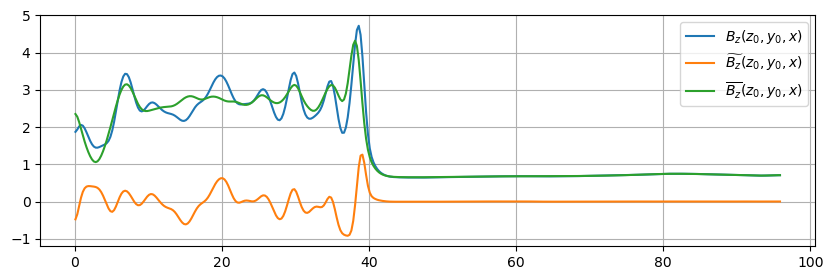

In [6]:
import matplotlib.pyplot as plt

#we typically work with the electric fields, 
#  but it's easier to understand if we look at the compressible component of the magnetic field

plt.figure(figsize=(10,3))
plt.plot(dfields['ex_xx'],dfields['bz'][0,0,:],label=r'$B_z(z_0,y_0,x)$')
plt.plot(dfields['ex_xx'],dfluc['bz'][0,0,:],label=r'$\widetilde{B_z}(z_0,y_0,x)$')
plt.plot(dfields['ex_xx'],dfavg['bz'][0,0,:],label=r'$\overline{B_z}(z_0,y_0,x)$')
plt.grid()
plt.legend()
plt.show()

In [7]:
#Do the wavelet transform of the fluctuating fields
#--------------------------------------------------

lowerresolution = True #lower field resolution for speed!
if(lowerresolution):
    print('dfields["ex"].shape before:',dfields['ex'].shape)
    dfields = FPCAnalysis.ao.avg_dict(dfields,binidxsz=[2,2,2]) #note, each element in binidxsz must be an integer divisor of the shape of its respective axis
    dfluc = FPCAnalysis.ao.avg_dict(dfluc,binidxsz=[2,2,2])
    dfavg = FPCAnalysis.ao.avg_dict(dfavg,binidxsz=[2,2,2])
    print('dfields["ex"].shape after:',dfields['ex'].shape)

dfields["ex"].shape before: (48, 48, 384)
dfields["ex"].shape after: (24, 24, 192)


In [8]:
#computes ex(kz,ky,kz;xx)
kz, ky, kx, exkzkykxxx = FPCAnalysis.anl.transform_field_to_kzkykxxx(dfields,'ex')
xx = dfields['ex_xx']

In [9]:
kz.shape,ky.shape,kx.shape,xx.shape,exkzkykxxx.shape

((24,), (24,), (384,), (192,), (24, 24, 384, 192))

In [ ]:
#plot the wavelet transform of the tot ex fields as a function of kx,x for a fixed value of ky,kz
kzidx = 0
kyidx = 0

print('kz,ky of this plot is ',kz[kzidx],ky[kyidx])

#vars that make model shock on bottom panel
Bz2_over_Bz1 = 3.8 #approx compression ratio
xpos_shock = 38.625 #position of jump of model shock
xpos_line = 39.875 #vertical black line

fieldvals = dfavg['bz'][0,0,:]

flnm = ''
ylim = [0,np.max(kx)]
FPCAnalysis.pltfr.plot_wlt_over_field(xx, kx, exkzkykxxx[kzidx,kyidx,::], fieldvals, flnm = flnm, ylim = ylim,
               Bz2_over_Bz1 = Bz2_over_Bz1, xpos_shock = xpos_shock, xpos_line = xpos_line)

kz,ky of this plot is  -1.0471975511965976 -0.5235987755982988
plotting hand assigned MHD comparison.....


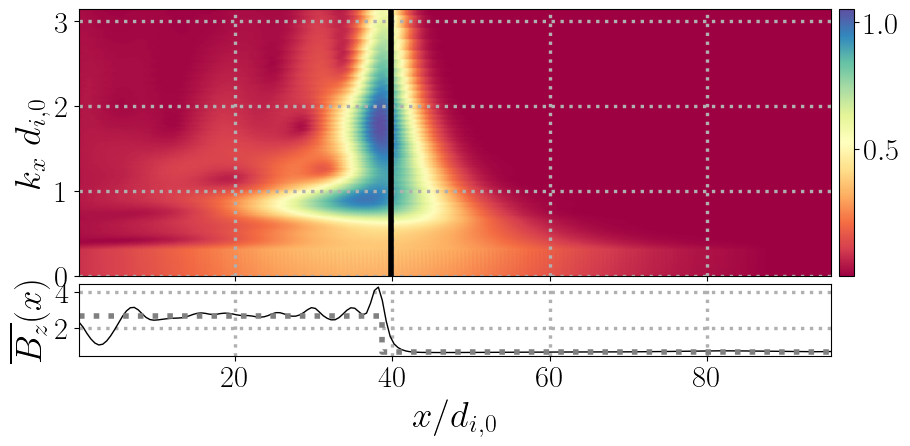

In [11]:
#Now, let's replicate Figure 5 From Brown et al 2023
kz, ky, kx, bxkzkykxxx = FPCAnalysis.anl.transform_field_to_kzkykxxx(dfluc,'bx')
kz, ky, kx, bykzkykxxx = FPCAnalysis.anl.transform_field_to_kzkykxxx(dfluc,'by')
kz, ky, kx, bzkzkykxxx = FPCAnalysis.anl.transform_field_to_kzkykxxx(dfluc,'bz')
xx = dfields['ex_xx']

kzidx = -2
kyidx = -1
print('kz,ky of this plot is ',kz[kzidx],ky[kyidx])

temp_array = np.stack((bxkzkykxxx[kzidx, kyidx, :, :], 
                       bykzkykxxx[kzidx, kyidx, :, :], 
                       bzkzkykxxx[kzidx, kyidx, :, :]), axis=-1)
wltplot1normbfluc = np.linalg.norm(temp_array, axis=-1)
del temp_array

#vars that make model shock on bottom panel
Bz2_over_Bz1 = 3.8 #approx compression ratio
xpos_shock = 38.625 #position of jump of model shock
xpos_line = 39.875 #vertical black line

fieldvals = dfavg['bz'][0,0,:]

flnm = ''
ylim = [0,np.max(kx)]
FPCAnalysis.pltfr.plot_wlt_over_field(xx, kx, wltplot1normbfluc, fieldvals, flnm = flnm, ylim = ylim,
               Bz2_over_Bz1 = Bz2_over_Bz1, xpos_shock = xpos_shock, xpos_line = xpos_line)

In [12]:
#let's compute the wave modes for each kx,ky,kz at chosen xx
#and then we can plot the measured omega/k vs relevant disp rels!
#----------------------------------------------------------------

kz, ky, kx, exkzkykxxx = FPCAnalysis.anl.transform_field_to_kzkykxxx(dfluc,'ex')
kz, ky, kx, eykzkykxxx = FPCAnalysis.anl.transform_field_to_kzkykxxx(dfluc,'ey')
kz, ky, kx, ezkzkykxxx = FPCAnalysis.anl.transform_field_to_kzkykxxx(dfluc,'ez')
kz, ky, kx, bxkzkykxxx = FPCAnalysis.anl.transform_field_to_kzkykxxx(dfluc,'bx')
kz, ky, kx, bykzkykxxx = FPCAnalysis.anl.transform_field_to_kzkykxxx(dfluc,'by')
kz, ky, kx, bzkzkykxxx = FPCAnalysis.anl.transform_field_to_kzkykxxx(dfluc,'bz')

In [13]:
#defines box that FAC is computed over
xlimfac = [39.875-.25,39.875+.25]
ylimfac = [0,12]
zlimfac = [0,12]

xx = 39.875

#create parallel arrays in dictionary of fields as a function of kz ky kx at specified xx
dwavemodes = FPCAnalysis.wv.compute_wavemodes(xx,dfields,xlimfac,ylimfac,zlimfac,
                     kx,ky,kz,
                     bxkzkykxxx,bykzkykxxx,bzkzkykxxx,
                     exkzkykxxx,eykzkykxxx,ezkzkykxxx)

In [14]:
#dwavemodes has several keys
#wavemodes has the wavenumber space information at specifed xx
#epar,eperp1/2 is the FAC basis (in box aligned coords)
#sortkey is the key that the arrays are sorted by (if sorted)
dwavemodes.keys()

dict_keys(['wavemodes', 'sortkey', 'epar', 'eperp1', 'eperp2'])

In [15]:
dwavemodes['wavemodes'][0].keys() #lets see all the fourier quantities we plotted. Most relevant is Epar/Eperp1/.../Bperp2(x0,kx0,ky0,kz0)

dict_keys(['kx', 'ky', 'kz', 'Bx', 'By', 'Bz', 'Ex', 'Ey', 'Ez', 'normB', 'normE', 'kpar', 'kperp1', 'kperp2', 'kperp', 'Epar', 'Eperp1', 'Eperp2', 'Bpar', 'Bperp1', 'Bperp2', 'EcrossBx', 'EcrossBy', 'EcrossBz', 'normEcrossB', 'EcrossBpar', 'EcrossBperp1', 'EcrossBperp2', 'Ee1', 'Ee2', 'Ee3', 'Be1', 'Be2', 'Be3', 'EcrossBe1', 'EcrossBe2', 'EcrossBe3', 'kdotB'])

In [16]:
len(dwavemodes['wavemodes']) #number of kz ky kx points where everything was computed ie 'wavemodes'

221184

In [17]:
for wvmdidx in range(0,5):
    print("The value of Epar(kz =",dwavemodes['wavemodes'][0]['kz']," ky = ",
        dwavemodes['wavemodes'][wvmdidx]['ky'], " kx = ", dwavemodes['wavemodes'][wvmdidx]['kx'], " x = ", xx,
        ') = ', dwavemodes['wavemodes'][wvmdidx]['Epar'])

The value of Epar(kz = 0.0  ky =  0.0  kx =  -3.141592653589793  x =  39.875 ) =  (9.280437813040607e-07-1.295067512054851e-06j)
The value of Epar(kz = 0.0  ky =  0.0  kx =  -3.141592653589793  x =  39.875 ) =  (-0.03287633066582213-0.14927847225846602j)
The value of Epar(kz = 0.0  ky =  0.0  kx =  -3.141592653589793  x =  39.875 ) =  (0.055804120366250175+0.02981539365716328j)
The value of Epar(kz = 0.0  ky =  0.0  kx =  -3.141592653589793  x =  39.875 ) =  (0.021235647479028435+0.022653466384164288j)
The value of Epar(kz = 0.0  ky =  0.0  kx =  -3.141592653589793  x =  39.875 ) =  (-0.04173472465559336+0.048938689495405314j)


In [18]:
#we can sort the array by chosen key
dwavemodes = FPCAnalysis.wv.sort_wavemodes(dwavemodes,'normB')
wvmdidx = 0
for wvmdidx in range(0,5):
    print("The value of normB(kz=",dwavemodes['wavemodes'][wvmdidx]['kz']," ky=",
        dwavemodes['wavemodes'][wvmdidx]['ky'], " kx=", dwavemodes['wavemodes'][wvmdidx]['kx'], " x=", xx,
        ')=', dwavemodes['wavemodes'][wvmdidx]['normB'])

The value of normB(kz= 1.0471975511965976  ky= 0.5235987755982988  kx= -1.7352776175587599  x= 39.875 )= 1.0146097215597427
The value of normB(kz= -1.0471975511965976  ky= -0.5235987755982988  kx= 1.7352776175587599  x= 39.875 )= 1.0146097215597427
The value of normB(kz= 1.0471975511965976  ky= 0.5235987755982988  kx= -1.7796875660650033  x= 39.875 )= 1.0070197576158224
The value of normB(kz= -1.0471975511965976  ky= -0.5235987755982988  kx= 1.7796875660650033  x= 39.875 )= 1.0070197576158222
The value of normB(kz= -1.0471975511965976  ky= -0.5235987755982988  kx= 1.676064352883769  x= 39.875 )= 1.0051089049347068


/home/crbrown/FPCAnalysis/FPCAnalysisenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/crbrown/FPCAnalysis/FPCAnalysisenv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


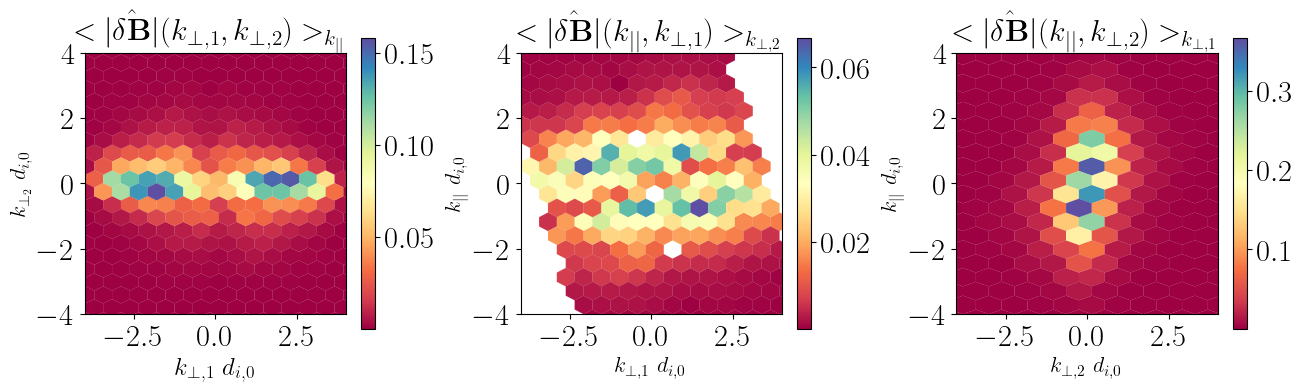

/home/crbrown/FPCAnalysis/FPCAnalysisenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/crbrown/FPCAnalysis/FPCAnalysisenv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


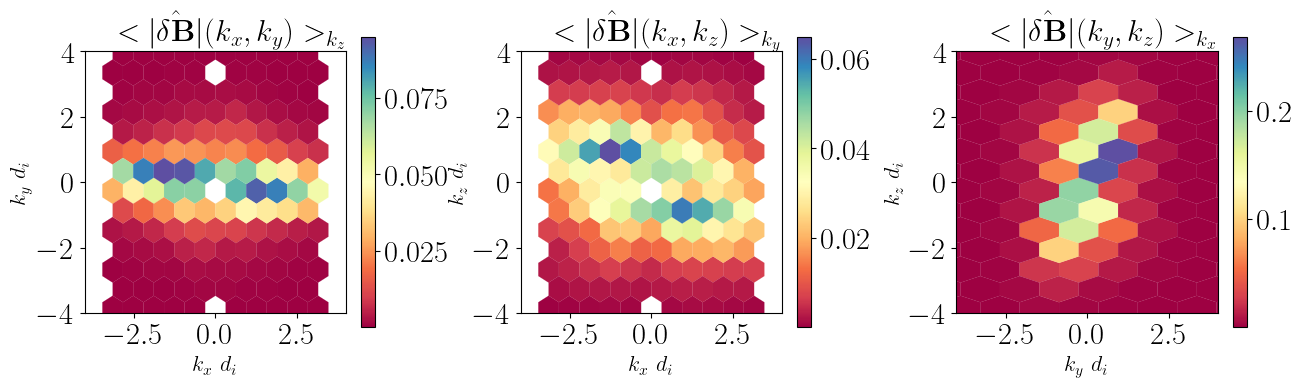

(<matplotlib.collections.PolyCollection at 0x7f90a894d090>,
 <matplotlib.collections.PolyCollection at 0x7f90a89e4550>)

In [19]:
#Let's replicate Figure 6 of Brown et al 2023
#Warning! The plots won't be identical due to two reasons
# One, We have converted sums to averages when 'projecting' (so the colorbars will be smaller)
# Two, a small sign change in the definition of FAC flips the middle figure!
# Three, if the fields were reduced in size above by averaging, the WLT will be different

speckey='normB'
gridsz = 20
FPCAnalysis.pltfr.plot_power_spectrum(dwavemodes,key=speckey,gridsize1=gridsz,gridsize2=gridsz,gridsize3=gridsz,
                                      kperp1lim = 4, kperp2lim=4, kparlim = 4)

gridsz = 10
FPCAnalysis.pltfr.plot_power_spectrum_cart(dwavemodes,key=speckey,gridsize1=gridsz,gridsize2=gridsz,gridsize3=gridsz,
                                      kxlim = 4, kylim=4, kzlim = 4)

In [33]:
#Measurements made elsewhere (for the M06_th45 dhybridr simulation at xx=39.875)
ntotlocalovernup=2.0447
btotlocaloverbtotup=1.7085

In [41]:

import importlib
importlib.reload(FPCAnalysis.ppl) #this reloads the data_dhybridr.py file! (see __init__.py for the aliases)inputs = FPCAnalysis.ddhr.read_input(path=path)


<module 'FPCAnalysis.plot.plotplume' from '/home/crbrown/FPCAnalysis/FPCAnalysis/plot/plotplume.py'>

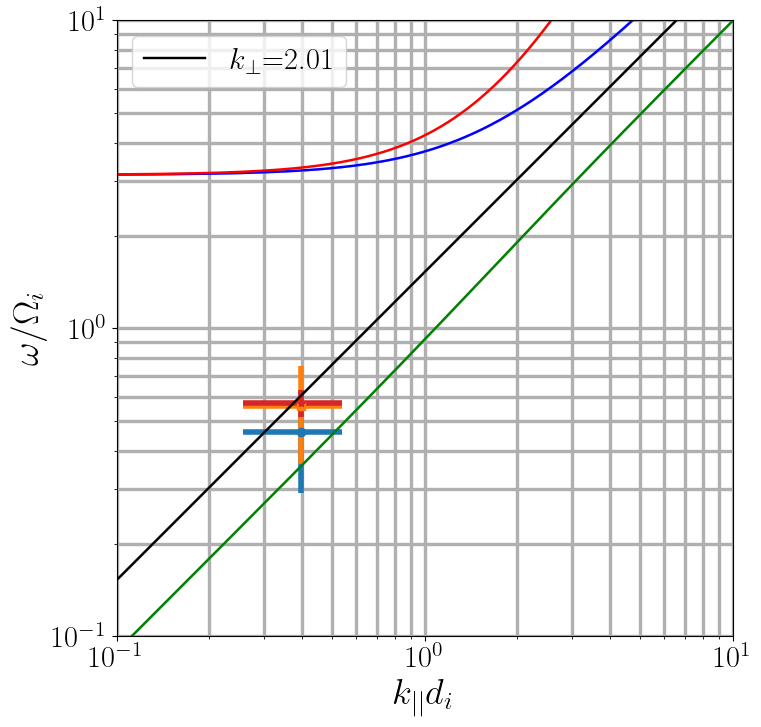

In [45]:
#Now, let's compute the dispersion relation using the IIM
wavemodeidx = 0 #pick the index of the wavemode to plot
wavemodes = [{'wavemodes':[dwavemodes['wavemodes'][wavemodeidx]]}]

for dwm in wavemodes[0]['wavemodes']:
    dwm['delta_kperp1'] = .2 #Approx val (note, in Brown et al 2023, we propogate the error from the kx from the wlt (using analytical expression to compute the error for the wlt with morlet wavelet))
                             # however, we omit that here for simplicity
    dwm['delta_kperp2'] = .2
    dwm['delta_kpar'] = .2

wavemodes[0]['wavemodes'][0] = FPCAnalysis.pl.rotate_and_norm_to_plume_basis(wavemodes[0]['wavemodes'][0],dwavemodes['epar'],
                                                               dwavemodes['eperp1'],dwavemodes['eperp2'],comp_error_prop=False)


kperps = [dwavemodes['wavemodes'][wavemodeidx]['kperp']] 
beta_i = 2. #approximate
tau = 1. #approximate
#WARNING: we take the abs value of omega when plotting (since the wlt can not distinguish direction)! (note, I believe it can distinguish relative direction between two waves tho! so be careful!) 
FPCAnalysis.ppl.plot_wavemodes_and_compare_to_sweeps_kpar(kperps,beta_i,tau,wavemodes,kparlim = [.1,10], flnm = '',
                                          xlim=[],ylim=[],ntotlocalovernup=ntotlocalovernup,btotlocaloverbtotup=btotlocaloverbtotup)

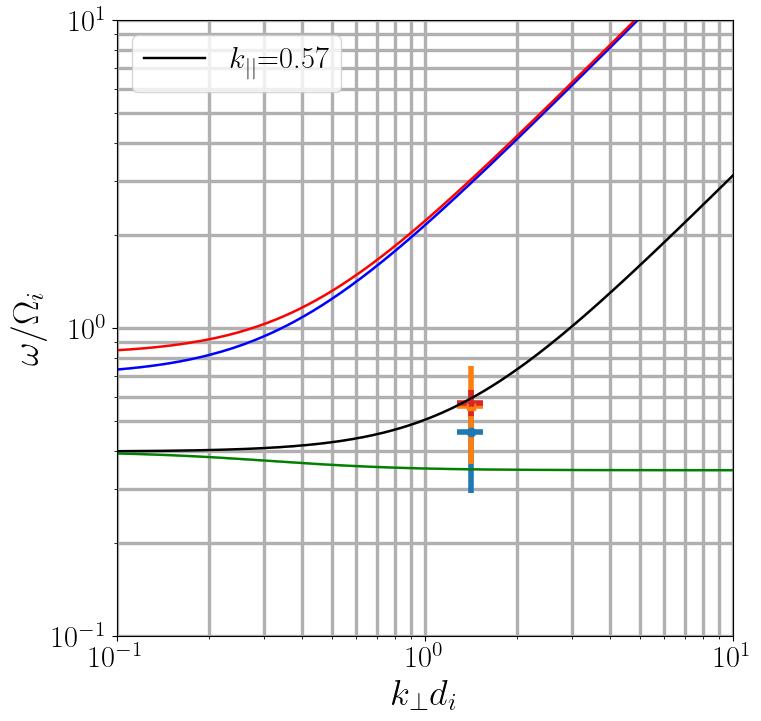

In [46]:
#repeat for kperp disprel
wavemodeidx = 0 #pick the index of the wavemode to plot
wavemodes = [{'wavemodes':[dwavemodes['wavemodes'][wavemodeidx]]}]

for dwm in wavemodes[0]['wavemodes']:
    dwm['delta_kperp1'] = .2 #Approx val (note, in Brown et al 2023, we propogate the error from the kx from the wlt (using analytical expression to compute the error for the wlt with morlet wavelet))
                             # however, we omit that here for simplicity
    dwm['delta_kperp2'] = .2
    dwm['delta_kpar'] = .2

wavemodes[0]['wavemodes'][0] = FPCAnalysis.pl.rotate_and_norm_to_plume_basis(wavemodes[0]['wavemodes'][0],dwavemodes['epar'],
                                                               dwavemodes['eperp1'],dwavemodes['eperp2'],comp_error_prop=False)
        

kpars = [np.abs(dwavemodes['wavemodes'][wavemodeidx]['kpar'])] #be careful to take abs!!
beta_i = 2.14 #approximate
tau = 2.17 #approximate
#WARNING: we take the abs value of omega when plotting (since the wlt can not distinguish direction)!
FPCAnalysis.ppl.plot_wavemodes_and_compare_to_sweeps_kperp(kpars,beta_i,tau,wavemodes,kperplim = [.1,10], flnm = '',
                                          xlim=[],ylim=[],ntotlocalovernup=ntotlocalovernup,btotlocaloverbtotup=btotlocaloverbtotup)

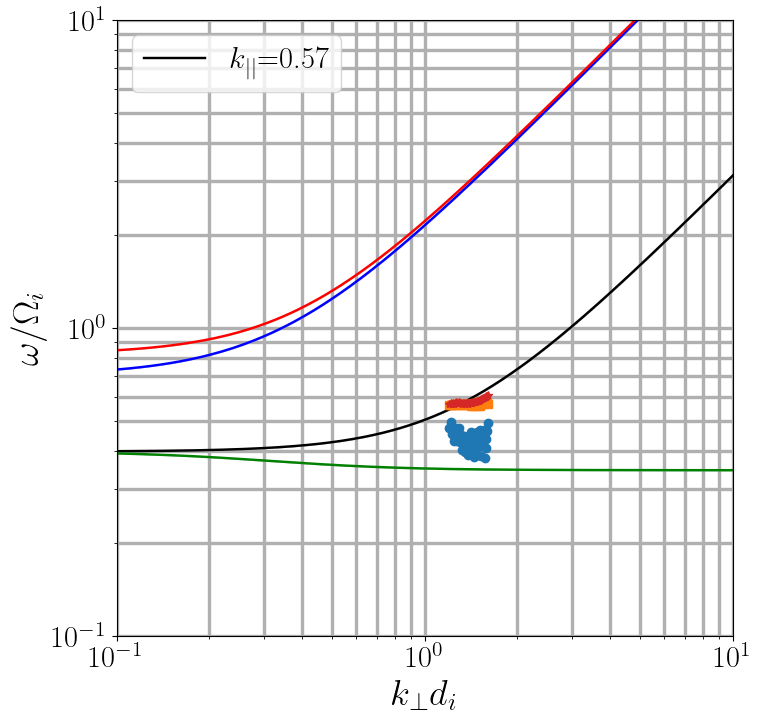

In [47]:
#repeat for kperp disprel, but for many dispersion rels
primarywavemodeidx = 0 #pick the index of the wavemode to plot
temparr = []
tol = .1
for _i in range(0,100):
    if(np.abs(dwavemodes['wavemodes'][_i]['kpar']-dwavemodes['wavemodes'][primarywavemodeidx]['kpar'])<tol):
        temparr.append(dwavemodes['wavemodes'][_i])
        
wavemodes = [{'wavemodes':temparr}]

for dwm in wavemodes[0]['wavemodes']:
    dwm['delta_kperp1'] = .0 #set to 0 to see points
    dwm['delta_kperp2'] = .0
    dwm['delta_kpar'] = .0
    
for _i in range(0,len(wavemodes[0]['wavemodes'])):
    wavemodes[0]['wavemodes'][_i] = FPCAnalysis.pl.rotate_and_norm_to_plume_basis(wavemodes[0]['wavemodes'][_i],dwavemodes['epar'],
                                                                   dwavemodes['eperp1'],dwavemodes['eperp2'],comp_error_prop=False)
        

kpars = [np.abs(dwavemodes['wavemodes'][primarywavemodeidx]['kpar'])] #be careful to take abs!!
beta_i = 2.14 #approximate
tau = 2.17 #approximate
FPCAnalysis.ppl.plot_wavemodes_and_compare_to_sweeps_kperp(kpars,beta_i,tau,wavemodes,kperplim = [.1,10], flnm = '',
                                          xlim=[],ylim=[],ntotlocalovernup=ntotlocalovernup,btotlocaloverbtotup=btotlocaloverbtotup)

In [49]:
#Now, that we know that our fluc fields is dominated by the desired physics, 
#let's compute the phase-space energization cauesd by this wave

vmax = 15
dv = .5
x1 = 39.5
x2 = 40.
y1 = 0
y2 = 12
z1 = 0
z2 = 12


vx, vy, vz, totalPtcl, hist, corex = FPCAnalysis.fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2,
                            dparticles, dfluc, 'ex')
vx, vy, vz, totalPtcl, hist, corey = FPCAnalysis.fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2,
                            dparticles, dfluc, 'ey')
vx, vy, vz, totalPtcl, hist, corez = FPCAnalysis.fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2,
                            dparticles, dfluc, 'ez')

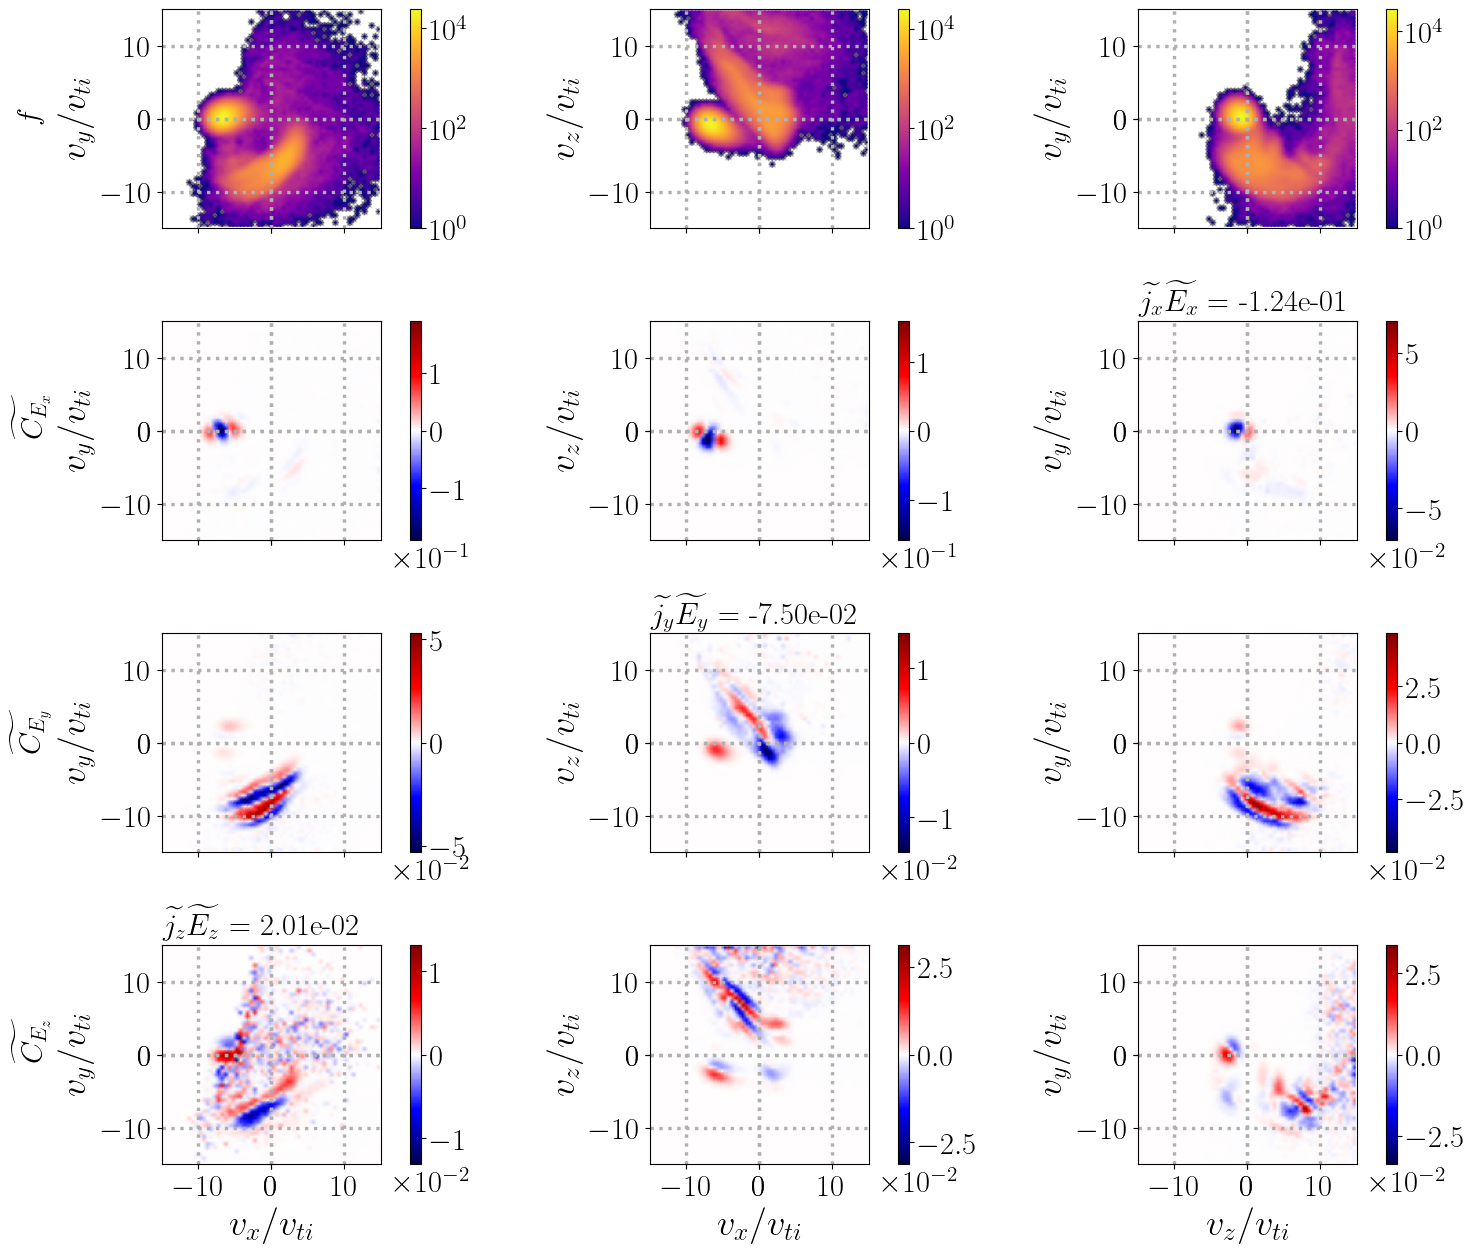

In [50]:
flnm = ''
#note the additonal plotFluc=True parameter!!!
FPCAnalysis.pltvv.project_and_plot_supergrid(vx,vy,vz,vmax,hist,corex,corey,corez,flnm=flnm,
                                            plotFluc=True)
